<a href="https://colab.research.google.com/github/kid-116/Mira/blob/main/2x2_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mira
## Quantum Sudoku Solver

### Import Libraries

In [ ]:
!pip install qiskit
!pip install qiskit[visualization]
!pip install pylatexenc

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import *
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Statevector

from qiskit.visualization import plot_histogram

### Helpers

In [3]:
DRAW_FORMAT = 'mpl'

In [4]:
def display_qc(qc):
  display(qc.draw(DRAW_FORMAT, fold=-1))

#### XOR Gate

In [5]:
def XOR(qc, a, b, output):
  qc.cx(a, output)
  qc.cx(b, output)

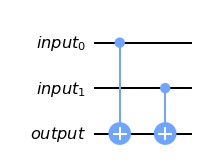

In [6]:
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
display(qc.draw(DRAW_FORMAT))

#### Grover Diffuser

In [58]:
def diffuser(nqubits, display_gate=False):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)

    # R0
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)
    qc.h(nqubits-1)
    for qubit in range(nqubits):
        qc.x(qubit)

    for qubit in range(nqubits):
        qc.h(qubit)
    if display_gate:
      display_qc(qc)
    U = qc.to_gate()
    U.name = 'U$_s$'
    return U

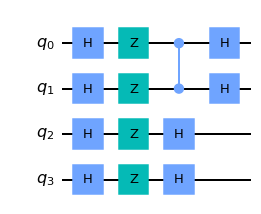

Instruction(name='U$_s$', num_qubits=4, num_clbits=0, params=[])

In [57]:
diffuser(4, True)

### Implementation

#### Clauses

In [8]:
# ┌─────────┐
# │ v0 | v1 │
# ├────┼────┤
# │ v2 | v3 │
# └─────────┘

# Defining pairs which shouldn't be equal in a valid solution
not_eq = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 3)
]

In [18]:
def sudoku_oracle(qc, clauses, clause_qubits, output_qubit):
    for i, clause in enumerate(clauses):
      XOR(qc, clause[0], clause[1], clause_qubits[i])

    qc.mct(clause_qubits, output_qubit)

    for i, clause in enumerate(not_eq):
      XOR(qc, clause[0], clause[1], clause_qubits[i])

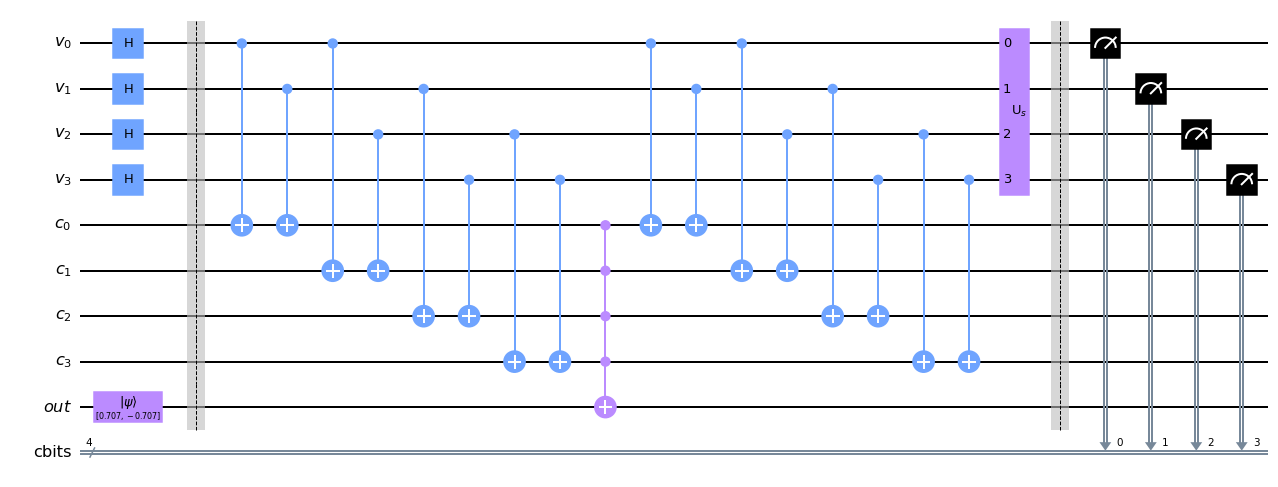

In [48]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(len(not_eq), name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')

qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

qc.initialize([1, -1]/np.sqrt(2), output_qubit)
qc.h(var_qubits)

qc.barrier()

sudoku_oracle(qc, not_eq, clause_qubits, output_qubit)
qc.append(diffuser(4), [0,1,2,3])

qc.barrier()

qc.measure(var_qubits, cbits)

display_qc(qc)

#### Execution

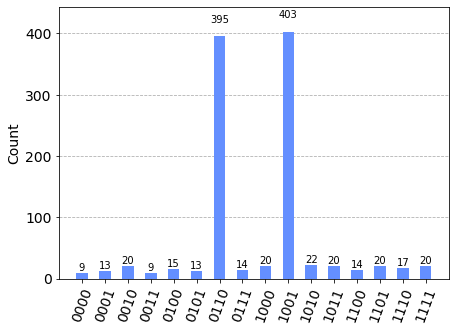

In [49]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_sim)
qobj = assemble(transpiled_qc)
result = aer_sim.run(qobj).result()
plot_histogram(result.get_counts())

#### Inference
We can infer that solutions 0110 and 1001 are valid by taking a quick look at the histogram above. 